In [1]:
from poloniex import Poloniex
from time import time
import json

polo = Poloniex()
start=time() - polo.YEAR

if False:
  data = polo.returnChartData('USDT_BTC', period=86400, start=start)
  with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

with open('data.json') as infile:
  market = json.load(infile)

import pandas as pd
df = pd.io.json.json_normalize(market)
df[list(df)] = df[list(df)].apply(pd.to_numeric)
#df['date'] = df['date'].apply(pd.to_datetime, unit='s')

,close,date,high,low,open,quoteVolume,volume,weightedAverage
328,16401.529,1513209600,16668.0,15451.0,15939.0,8540.163531,1.379926e+08,16158.073346


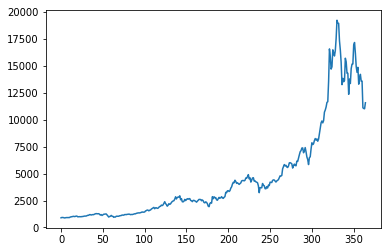

In [2]:
import matplotlib
%matplotlib inline
df.describe()
df['close'].plot()
df.sample()

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/Users/hild/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


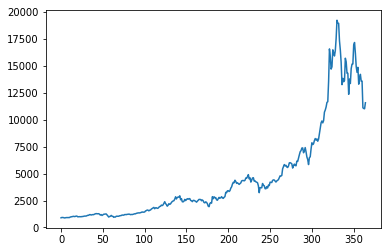

In [29]:
# fix random seed for reproducibility
numpy.random.seed(7)
#dataset = df.loc[:, df.columns != 'date']
dataset = df[['close']]
dataset.sample()
plt.plot(dataset)
plt.show()

In [30]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [31]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

244 121


In [32]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [33]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [34]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 1s - loss: 0.0049
Epoch 2/10
 - 1s - loss: 0.0037
Epoch 3/10
 - 1s - loss: 0.0032
Epoch 4/10
 - 1s - loss: 0.0027
Epoch 5/10
 - 1s - loss: 0.0020
Epoch 6/10
 - 1s - loss: 0.0013
Epoch 7/10
 - 1s - loss: 7.3021e-04
Epoch 8/10
 - 1s - loss: 3.0487e-04
Epoch 9/10
 - 1s - loss: 1.1068e-04
Epoch 10/10
 - 1s - loss: 6.2413e-05


In [36]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 131.84 RMSE
Test Score: 944.54 RMSE


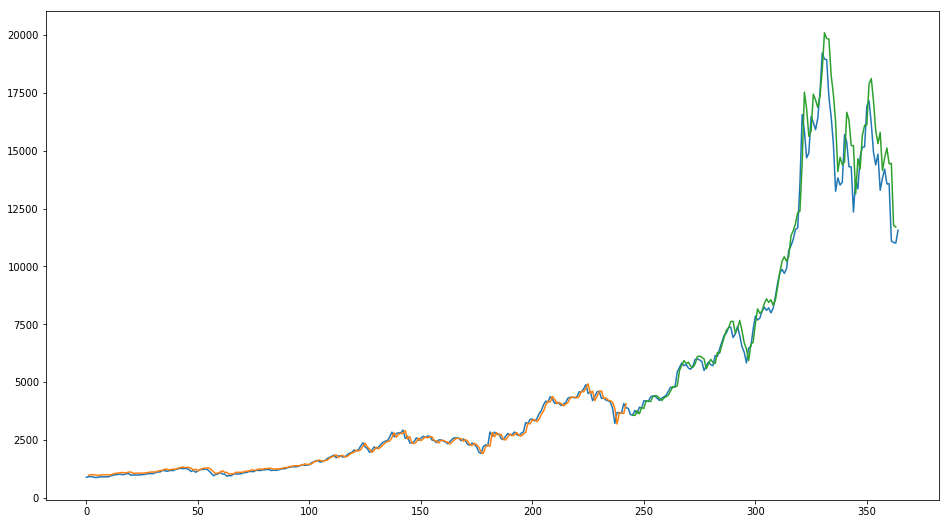

In [38]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()